# Progetto Machine Learning for Vision and Multimedia

## Seconda parte: ResNet18

### Import

In [17]:
import os
import numpy as np
import pandas as pd
import math
import random
import copy
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
from torch.nn.functional import pad
from torchvision.utils import save_image
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score
import re

import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Palette images with Transparency expressed in bytes should be converted to RGBA images")
warnings.filterwarnings("ignore", category=UserWarning, message="Metric `InceptionScore` will save all extracted features in buffer.*")
warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*os.fork.*")

## Variabili

In [18]:
#Variabili da tenere in considerazione

# Numero di categorie di segnali stradali
n_class = 8

# Dimensione immagine (pixel)
dim_immagine = 64
image_size = dim_immagine

# Batch size durante l'addestramento
batch_size = 128

# Numero canali
nc = 3

In [19]:
dataroot='/kaggle/input/russian-road-signs-categories-dataset'

In [20]:
class RoadSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')

        # Aggiungi padding per rendere l'immagine quadrata
        img = self.pad_to_square(img)

        img = img.resize((dim_immagine,dim_immagine))

        if self.transform:
            img = self.transform(img)

        return img, label

    #funzione creata per mettere il padding e rendere l'immagine quadrata
    def pad_to_square(self, img):

        # Converti l'immagine in un tensore
        img_tensor = transforms.ToTensor()(img)

        # Calcola la dimensione massima tra altezza e larghezza
        max_size = max(img.size)
        (width, height) = img.size

        pad_top = 0
        pad_left = 0
        pad_right = 0
        pad_bottom = 0

        if width >= height:
          padding = (width - height) // 2
          pad_top = padding
          pad_bottom = padding
          if (width - height) % 2 == 1:
            pad_top += 1
        else:
          padding = (-width + height) // 2
          pad_left = padding
          pad_right = padding
          if (-width + height) % 2 == 1:
            pad_left += 1

        # Applica il padding
        img_tensor = pad(img_tensor, (pad_left, pad_right, pad_top, pad_bottom), value=0)

        # Converte il tensore risultante in un'immagine
        img_padded = transforms.ToPILImage()(img_tensor)

        return img_padded

In [21]:
def get_dataset(i):
    transform = transforms.Compose([transforms.Resize((image_size, image_size)),
                                    #transforms.CenterCrop(image_size),
                                    #transforms.RandomCrop(32, padding=2),
                                    #transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    path_root = dataroot
    
    
    if i == 0: #caso Training
        path_root = os.path.join(dataroot, "train")
        
    if i == 1: #caso Validation
        path_root = os.path.join(dataroot, "test")

    dataset = RoadSignsDataset(root_dir=path_root, transform=transform)

    dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

    return dataset, dataloader

In [22]:
# Ottieni il dataset e il dataloader
dataset, dataloader = get_dataset(0)

In [23]:
# Poiché le dimensioni delle immagini sono 64x64, 
# utilizziamo un modello CNN più semplice, adattando una rete come ResNet18.

class_names = dataset.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# Modificare ResNet18 per lavorare con immagini 64x64
model = models.resnet18(pretrained=False)

# Adattare il primo layer per gestire immagini 64x64
model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.avgpool = nn.AdaptiveAvgPool2d((1, 1))

# Modificare il classifier
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [24]:
# Estrazione di un batch di immagini e label dal dataloader
batch_images, batch_labels = next(iter(dataloader))

In [25]:
# Decodifica delle immagini normalizzate
batch_images = batch_images * 0.5 + 0.5  # Reverti la normalizzazione

# Trasforma i tensori in numpy array
#successivamente rimosso perche batch_size è gia un numpy

batch_images = batch_images.numpy()
batch_labels = batch_labels.numpy()

# Definisci le classi
classes = dataset.classes


In [26]:
# Definisco la funzione di perdita e l'ottimizzatore (qui configuro il processo di training)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [27]:
# Ottengo i dataloader per il training e la validazione
train_dataset, train_dataloader = get_dataset(0)  # 0 per il training
val_dataset, val_dataloader = get_dataset(1)  # 1 per la validazione

# Crea un dizionario con i dataloader
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Crea un dizionario con le dimensioni dei dataset
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

In [28]:
# Per salvare grafici
plot_save_training_path = '/kaggle/working/plot_images'
os.makedirs(plot_save_training_path, exist_ok=True)

In [29]:
# Funzione per calcolare le metriche di classificazione
def calculate_classification_metrics(true_labels, predicted_labels):
    precision = precision_score(true_labels, predicted_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    accuracy = accuracy_score(true_labels, predicted_labels)
    return accuracy, precision, recall, f1

#-----------------------------------------------------------------------

# Funzione per tracciare e salvare le curve di perdita del Generatore e del Discriminatore
def plot_and_save_losses(train_losses, val_losses, epoch, plot_save_training_path):
    plt.figure(figsize=(10, 5))
    plt.title("Loss durante training e validation")
    plt.plot(train_losses, label="Training")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Iterazioni")
    plt.ylabel("Loss")
    plt.legend()

    # Salvataggio del grafico
    loss_plot_path = os.path.join(plot_save_training_path, f'epoch_{epoch}_loss_plot.png')
    plt.savefig(loss_plot_path)
    print(f"Loss plot saved at {loss_plot_path}")
    
#-----------------------------------------------------------------------

# Funzione per tracciare e salvare le metriche di performance
def plot_and_save_metrics(vec_acc, vec_rec, vec_prec, vec_f1, epoch, plot_save_training_path, train_or_val):
    metrics = {
        'Accuracy': vec_acc,
        'Recall': vec_rec,
        'Precision': vec_prec,
        'F1-Score': vec_f1,
    }
    
    for metric_name, metric_values in metrics.items():
        plt.figure(figsize=(10, 5))
        plt.title(f"{metric_name} during {train_or_val}")
        plt.plot(metric_values, label=metric_name)
        plt.xlabel("Epoch")
        plt.ylabel(metric_name)
        plt.legend()
        
        # Salvataggio del grafico
        if train_or_val == "Training":
            metric_plot_path = os.path.join(plot_save_training_path, f'epoch_{epoch}_{metric_name.lower().replace(" ", "_")}_plot_training.png')
        elif train_or_val == "Validation":
            metric_plot_path = os.path.join(plot_save_training_path, f'epoch_{epoch}_{metric_name.lower().replace(" ", "_")}_plot_validation.png')
        plt.savefig(metric_plot_path)
        print(f"{metric_name} plot saved at {metric_plot_path}")

In [30]:
# Funzione per trovare il checkpoint con il numero più alto (ovvero il più aggiornato)

def find_latest_checkpoint():
    checkpoints = glob.glob('checkpoint_epoch_*.pth')
    if not checkpoints:
        return None
    
    # Estrae il numero dai nomi dei file e trova il massimo
    max_checkpoint = max(checkpoints, key=lambda x: int(re.findall(r'\d+', x)[0]))
    return max_checkpoint


def train_model(model, criterion, optimizer, num_epochs=25, checkpoint_path='checkpoint.pth'):
    
    #-----------------------------------------------------------------------
    
    # Caricamento dell'ultimo checkpoint (se esiste)
    latest_checkpoint_path = find_latest_checkpoint()
    
    if latest_checkpoint_path:
        try:
            # Carica il checkpoint sulla CPU per evitare errori di dispositivi
            checkpoint = torch.load(latest_checkpoint_path, map_location=torch.device('cpu'), weights_only=False)

            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            best_model_wts = checkpoint['best_model_wts']
            best_acc = checkpoint['best_acc']
            best_precision = checkpoint.get('best_precision', 0.0)
            best_recall = checkpoint.get('best_recall', 0.0)
            best_f1 = checkpoint.get('best_f1', 0.0)

            # Carica le metriche salvate
            train_losses = checkpoint['train_losses']
            val_losses = checkpoint['val_losses']
            vec_acc_t = checkpoint['vec_acc_t']
            vec_rec_t = checkpoint['vec_rec_t']
            vec_prec_t = checkpoint['vec_prec_t']
            vec_f1_t = checkpoint['vec_f1_t']
            vec_acc_v = checkpoint['vec_acc_v']
            vec_rec_v = checkpoint['vec_rec_v']
            vec_prec_v = checkpoint['vec_prec_v']
            vec_f1_v = checkpoint['vec_f1_v']
            iters = checkpoint['iters']
            start_epoch = checkpoint['epoch'] + 1  # Riprende dall'epoca successiva

            print(f"Checkpoint found: {latest_checkpoint_path}. Resuming training from epoch", start_epoch)

        except (RuntimeError, FileNotFoundError, KeyError) as e:
            print("Error loading checkpoint:", e)
            print("No valid checkpoint found. Starting training from scratch.")

            # Inizializzazione da zero in caso di errore o assenza di checkpoint
            start_epoch = 0
            iters = 0
            train_losses, val_losses = [], []
            vec_acc_t, vec_rec_t, vec_prec_t, vec_f1_t = [], [], [], []
            vec_acc_v, vec_rec_v, vec_prec_v, vec_f1_v = [], [], [], []
            start_epoch = 0
            best_acc = 0.0
            best_precision = 0.0
            best_recall = 0.0
            best_f1 = 0.0
            best_model_wts = copy.deepcopy(model.state_dict())
            
 
    else:
        print("No checkpoint found. Starting training from scratch.")

        # Inizializzazione da zero se nessun checkpoint è disponibile
        start_epoch = 0
        iters = 0
        train_losses, val_losses = [], []
        vec_acc_t, vec_rec_t, vec_prec_t, vec_f1_t = [], [], [], []
        vec_acc_v, vec_rec_v, vec_prec_v, vec_f1_v = [], [], [], []
        start_epoch = 0
        best_acc = 0.0
        best_precision = 0.0
        best_recall = 0.0
        best_f1 = 0.0
        best_model_wts = copy.deepcopy(model.state_dict())


    
    
    #-----------------------------------------------------------------------
    

    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                phase_dataloader = dataloaders['train']
            else:
                model.eval()
                phase_dataloader = dataloaders['val']

            running_loss = 0.0
            running_corrects = 0

            all_preds = []
            all_labels = []

            for inputs, labels in tqdm(phase_dataloader, desc=f"{phase.capitalize()} Progress", leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                if phase == 'train':
                    optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Calcolo precision, recall, e F1-score
            epoch_precision = precision_score(all_labels, all_preds, average='macro')
            epoch_recall = recall_score(all_labels, all_preds, average='macro')
            epoch_f1 = f1_score(all_labels, all_preds, average='macro')
            
            if phase == 'train':
                vec_prec_t.append(epoch_precision)
                vec_acc_t.append(epoch_acc)         
                vec_rec_t.append(epoch_recall)
                vec_f1_t.append(epoch_f1)
                train_losses.append(epoch_loss)
                if epoch % 5 == 0:
                    plot_and_save_metrics(vec_acc_t, vec_rec_t, vec_prec_t, vec_f1_t, epoch, plot_save_training_path, "Training")
                
            if phase == 'val':
                vec_prec_v.append(epoch_precision)
                vec_acc_v.append(epoch_acc)         
                vec_rec_v.append(epoch_recall)
                vec_f1_v.append(epoch_f1) 
                val_losses.append(epoch_loss)
                if epoch % 5 == 0:
                    plot_and_save_metrics(vec_acc_v, vec_rec_v, vec_prec_v, vec_f1_v, epoch, plot_save_training_path, "Validation")

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1-Score: {epoch_f1:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_precision = epoch_precision
                best_recall = epoch_recall
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
                
        # Grafici e salvataggio ogni 5 epoche
        plot_and_save_losses(train_losses, val_losses, epoch, plot_save_training_path)

        # Salvataggio del checkpoint ogni epoca
        checkpoint_path = f'checkpoint_epoch_{epoch}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'iters': iters,
            'vec_acc_t': vec_acc_t,
            'vec_prec_t': vec_prec_t,
            'vec_rec_t': vec_rec_t,
            'vec_f1_t': vec_f1_t,
            'vec_acc_v': vec_acc_v,
            'vec_prec_v': vec_prec_v,
            'vec_rec_v': vec_rec_v,
            'vec_f1_v': vec_f1_v,
            'best_model_wts': best_model_wts,
            'best_acc': best_acc,
            'best_precision': best_precision,
            'best_recall': best_recall,
            'best_f1': best_f1,
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,  # Salva l'ultima loss dell'epoca
            
        }, checkpoint_path)
        
        print(f"Checkpoint saved: {checkpoint_path}")

    print(f'Best val Acc: {best_acc:.4f} Precision: {best_precision:.4f} Recall: {best_recall:.4f} F1-Score: {best_f1:.4f}')
    model.load_state_dict(best_model_wts)
    return model

Checkpoint found: checkpoint_epoch_7.pth. Resuming training from epoch 8
Epoch 8/10
----------


train Loss: 0.0020 Acc: 0.9999 Precision: 0.9999 Recall: 0.9999 F1-Score: 0.9999


val Loss: 0.0182 Acc: 0.9940 Precision: 0.9940 Recall: 0.9940 F1-Score: 0.9940
Loss plot saved at /kaggle/working/plot_images/epoch_8_loss_plot.png
Checkpoint saved: checkpoint_epoch_8.pth
Epoch 9/10
----------


train Loss: 0.0017 Acc: 0.9999 Precision: 0.9999 Recall: 0.9999 F1-Score: 0.9999


val Loss: 0.0164 Acc: 0.9946 Precision: 0.9946 Recall: 0.9946 F1-Score: 0.9946
Loss plot saved at /kaggle/working/plot_images/epoch_9_loss_plot.png
Checkpoint saved: checkpoint_epoch_9.pth
Epoch 10/10
----------


Accuracy plot saved at /kaggle/working/plot_images/epoch_10_accuracy_plot_training.png
Recall plot saved at /kaggle/working/plot_images/epoch_10_recall_plot_training.png
Precision plot saved at /kaggle/working/plot_images/epoch_10_precision_plot_training.png
F1-Score plot saved at /kaggle/working/plot_images/epoch_10_f1-score_plot_training.png
train Loss: 0.0014 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1-Score: 1.0000


Accuracy plot saved at /kaggle/working/plot_images/epoch_10_accuracy_plot_validation.png
Recall plot saved at /kaggle/working/plot_images/epoch_10_recall_plot_validation.png
Precision plot saved at /kaggle/working/plot_images/epoch_10_precision_plot_validation.png
F1-Score plot saved at /kaggle/working/plot_images/epoch_10_f1-score_plot_validation.png
val Loss: 0.0163 Acc: 0.9945 Precision: 0.9945 Recall: 0.9945 F1-Score: 0.9945
Loss plot saved at /kaggle/working/plot_images/epoch_10_loss_plot.png
Checkpoint saved: checkpoint_epoch_10.pth
Best val Acc: 0.9946 Precision: 0.9946 Recall: 0.9946 F1-Score: 0.9946


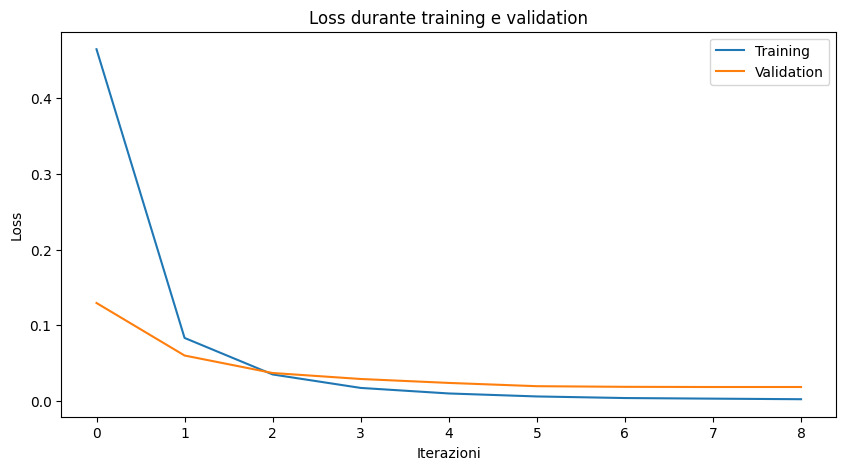

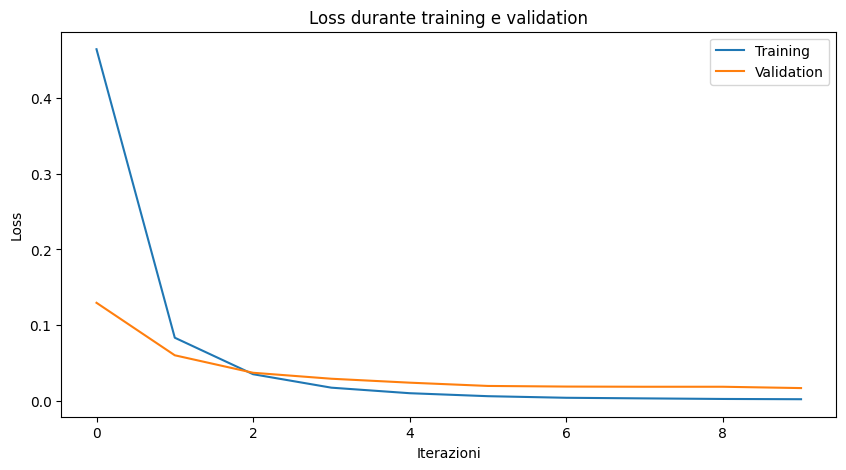

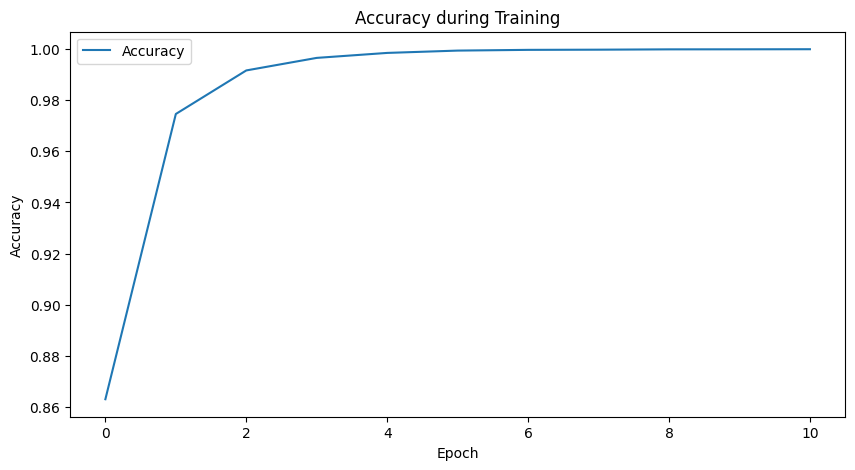

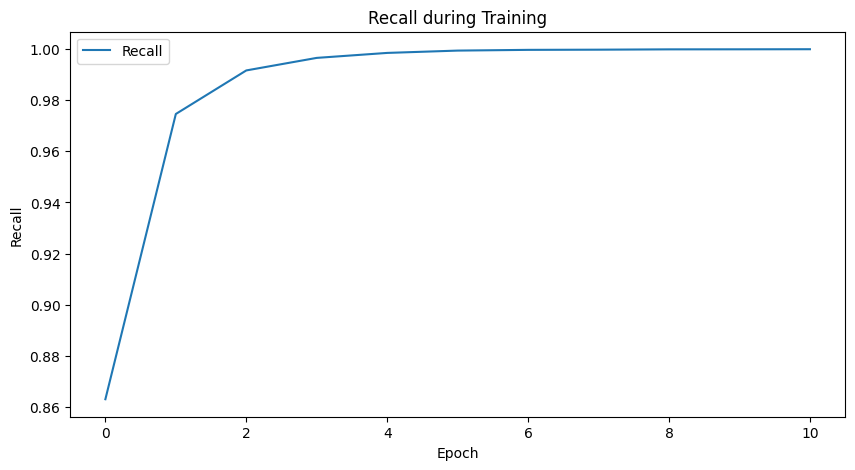

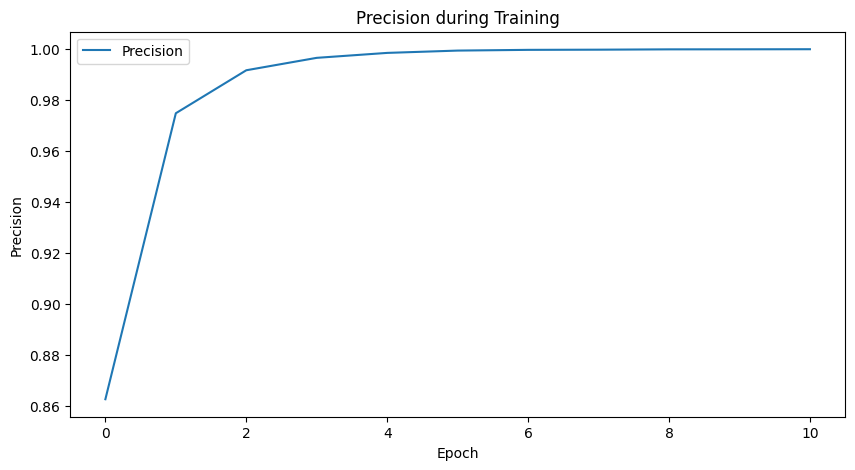

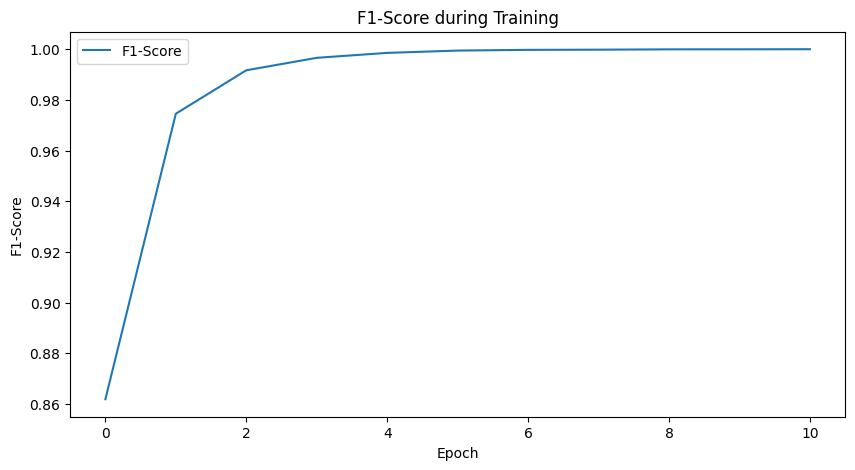

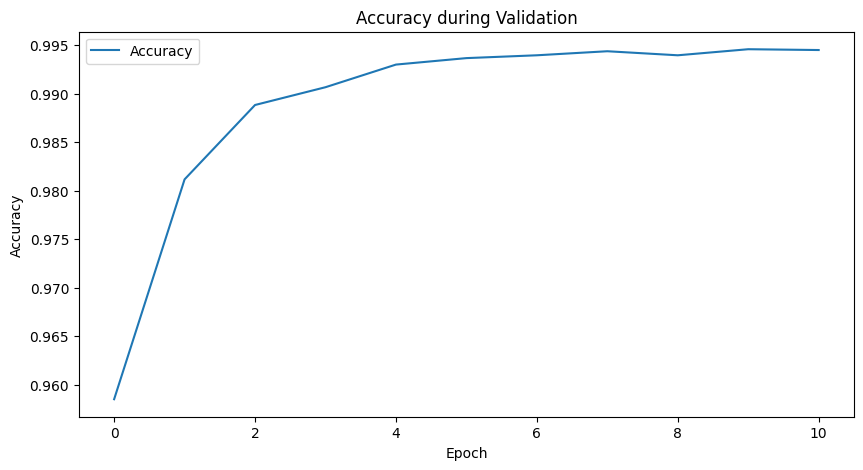

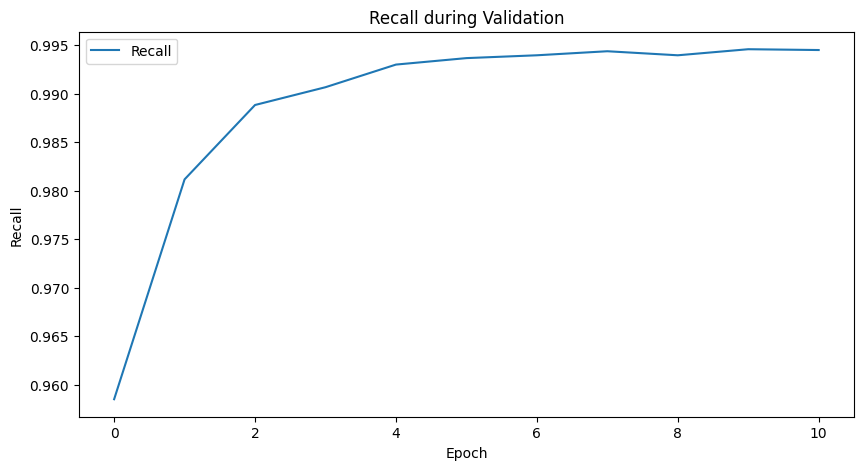

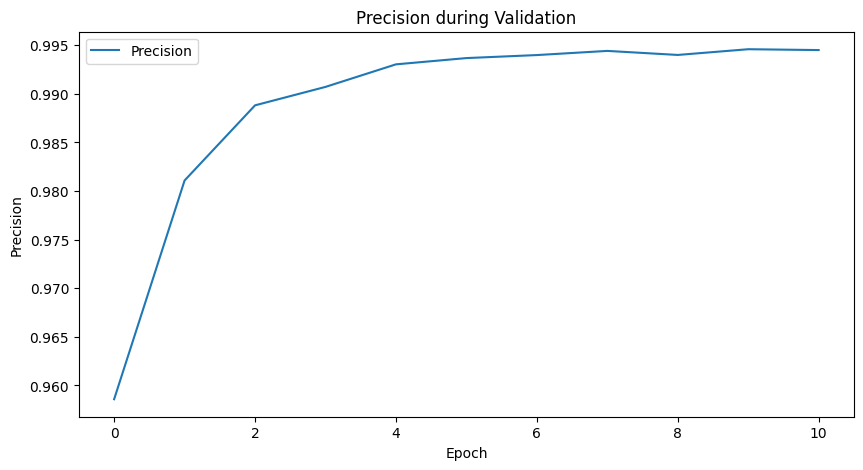

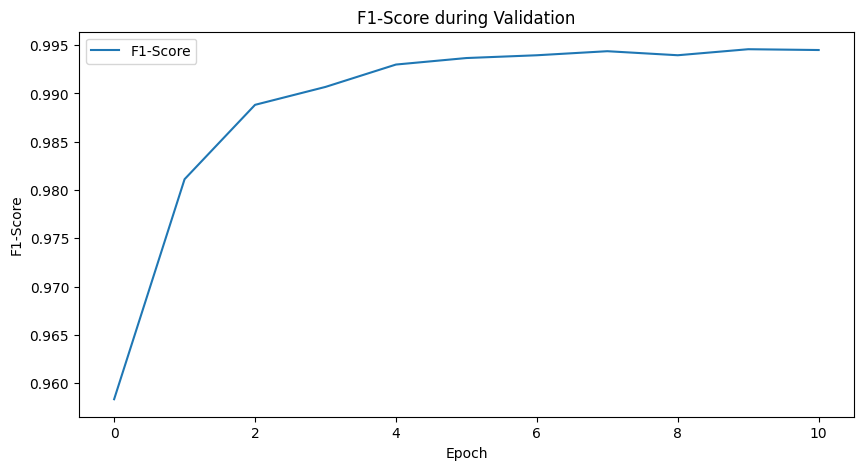

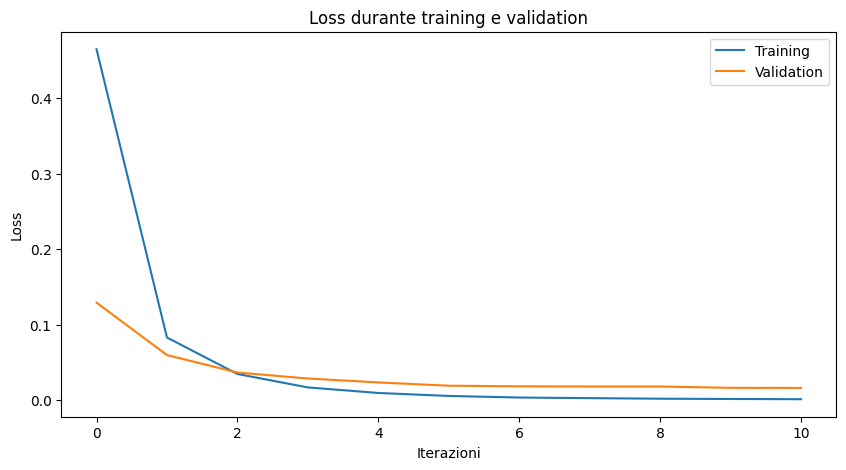

In [33]:
# Imposta il percorso del checkpoint
checkpoint_path = 'checkpoint.pth'

# Avvia l'addestramento o riprendi da un checkpoint
model = train_model(model, criterion, optimizer, num_epochs=11, checkpoint_path=checkpoint_path)

In [ ]:
#Carica il checkpoint più recente
#Codice da runnare quando non si vuole eseguire il training ma solo fare un test
latest_checkpoint_path = find_latest_checkpoint()
    
if latest_checkpoint_path:
    try:
        # Carica il checkpoint sulla CPU per evitare errori di dispositivi
        checkpoint = torch.load(latest_checkpoint_path, map_location=torch.device('cpu'), weights_only=False)

        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_model_wts = checkpoint['best_model_wts']
        best_acc = checkpoint['best_acc']
        best_precision = checkpoint.get('best_precision', 0.0)
        best_recall = checkpoint.get('best_recall', 0.0)
        best_f1 = checkpoint.get('best_f1', 0.0)

        # Carica le metriche salvate
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        vec_acc_t = checkpoint['vec_acc_t']
        vec_rec_t = checkpoint['vec_rec_t']
        vec_prec_t = checkpoint['vec_prec_t']
        vec_f1_t = checkpoint['vec_f1_t']
        vec_acc_v = checkpoint['vec_acc_v']
        vec_rec_v = checkpoint['vec_rec_v']
        vec_prec_v = checkpoint['vec_prec_v']
        vec_f1_v = checkpoint['vec_f1_v']
        iters = checkpoint['iters']
        start_epoch = checkpoint['epoch'] + 1  # Riprende dall'epoca successiva
        print(f"Checkpoint found: {latest_checkpoint_path}. Resuming training from epoch", start_epoch)

    except (RuntimeError, FileNotFoundError, KeyError) as e:
        print("Error loading checkpoint:", e)

else:
    print("No checkpoint found. Starting training from scratch.")


In [34]:
#mapping segnali

def mapping_signs(code_s):
    
    code = int(code_s)
    if code == 1:
        return "Pericolo"
    elif code == 2:
        return "Priorità"
    elif code == 3:
        return "Divieto"
    elif code == 4:
        return "Obbligo"
    elif code == 5:
        return "Regolamentazione"
    elif code == 6:
        return "Informazione"
    elif code == 7:
        return "Servizi"
    elif code == 8:
        return "Pannelli integrativi"
    else:
        return "Non trovato"

In [35]:
#funzioni di mapping

def index_to_sign(classes, idx):
    if idx<0 | idx>len(classes)-1:
        return 'no_one'
    return classes[idx]

def sign_to_index(classes, my_sign):
    for i, sign in enumerate(classes):
        if my_sign == sign:
            return i
    return -1

In [38]:
#Codice per testare un segnale alla volta

model.eval()  # Imposta il modello in modalità valutazione

# Definisce le trasformazioni per l'immagine
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Ridimensiona l'immagine a 64x64
    transforms.ToTensor(),  # Converte l'immagine in un tensore
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizza tra -1 e 1
])

# Funzione per caricare e preprocessare l'immagine
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')  # Apre l'immagine e la converte in RGB
    img = transform(img)  # Applica le trasformazioni
    img = img.unsqueeze(0).to(device)   # Aggiunge una dimensione batch
    return img

# Funzione per fare la previsione
def predict_sign(img_path):
    img = preprocess_image(img_path)
    with torch.no_grad():  # Disabilita il calcolo dei gradienti
        predictions = model(img)
    predicted_class = predictions.argmax(dim=1).item()
    return predicted_class

# Test del modello su un nuovo quadro
image_path = '/kaggle/input/fake-signals-141/image_1006_3.png'
predicted_label = predict_sign(image_path)

# Stampa il risultato
print(f"Il quadro è stato classificato come: {mapping_signs(index_to_sign(classes, predicted_label))} ({index_to_sign(classes, predicted_label)})")


Il quadro è stato classificato come: Divieto (3)


# TESTING IMMAGINI FAKE

In [39]:
#Codice per testare più immagini fake alla volta e calcolare una percentiale di successo

image_dir = '/kaggle/input/fake-signals-141'

cont = 0
tot = 0

for image_file in os.listdir(image_dir):
    if image_file.endswith('.jpg') or image_file.endswith('.png'):  # Filtrare solo immagini
        image_path = os.path.join(image_dir, image_file)
        label = image_file.split('_')[-1].split('.')[0]
        #label -> etichetta vera del segnale
        #print(f"Immagine: {image_file}, Etichetta: {label}")
        
        predicted_label = predict_sign(image_path)
        predicted_label = index_to_sign(classes, predicted_label)
        
        #print(f"{label} --- {predicted_label}")
        #predicted_label -> etichetta predetta del segnale
        
        if label == predicted_label:
            cont =+ 1
            
        tot =+ 1
        
print(f"Percentuale di successo: {(cont/tot)*100}%")


Percentuale di successo: 100.0%
